In [16]:
from pathlib import Path
import openmm
import openmm.app as openmm_app
from tqdm import tqdm as _tqdm
from tools import base, simulator
from tools.simulator import MSDReporter

In [72]:
def create_simulation(
    system_path: Path,
    topology_path: Path,
    result_dir: Path,
    dt=1,
    T=25,
    check_freq=1000,
):
    fs = openmm.unit.femtoseconds

    dt = dt * fs
    temperature = (T + 273) * openmm.unit.kelvin
    friction = 1 / openmm.unit.picosecond
    pdb = openmm_app.PDBFile(topology_path.as_posix())
    topology = pdb.topology

    with open(system_path.as_posix(), 'r') as system_file:
        system: openmm.System = openmm.XmlSerializer.deserialize(system_file.read())
    # ADD forces
    system.addForce(openmm.CMMotionRemover())

    integrator = openmm.LangevinIntegrator(temperature, friction, dt)

    platform = openmm.Platform.getPlatformByName('CUDA')
    platformProperties = {'Precision': 'single'}
    platformProperties["DeviceIndex"] = "0"

    simulation = openmm_app.Simulation(
        topology=topology,
        system=system,
        integrator=integrator,
        platform=platform,
        platformProperties=platformProperties,
    )
    simulation.context.setPositions(pdb.positions)

    equilibration_stage = _tqdm(iterable=range(2))
    equilibration_stage.set_description_str('Equilibration')
    simulation.minimizeEnergy()
    simulation.context.setVelocitiesToTemperature(temperature)
    simulation.context.reinitialize(preserveState=True)
    for i in equilibration_stage:
        simulation.step(1000)

    simulation.currentStep = 0
    simulation.context.setVelocitiesToTemperature(temperature)

    msdReporter = MSDReporter(check_freq, simulation, dt)
    simulation.reporters.append(msdReporter)
    return simulation, msdReporter


def simulate(system_path: Path, topology_path: Path, result_dir: Path, T):
    print('#' * 30, f'Temperature: {T:2} C')
    simulation, reporter = create_simulation(
        system_path=system_path,
        topology_path=topology_path,
        result_dir=result_dir,
        dt=1,
        check_freq=1000,
        T=T,
    )
    product_cycle = _tqdm(iterable=range(10))
    product_cycle.set_description_str('Product      ')
    for i in product_cycle:
        simulation.step(1000)
    print()
    return reporter


In [73]:
a= create_simulation(
    system_path=Path('systems/ocm_0_1720/system.xml'),
    topology_path=Path('systems/ocm_0_1720/top.pdb'),
    result_dir=Path('.'),
    T=25,
)

Equilibration: 100%|██████████| 2/2 [00:11<00:00,  5.65s/it]


In [84]:
a[0].step(100000)

In [80]:
import matplotlib.pyplot as plt

In [86]:
df = a[1].df

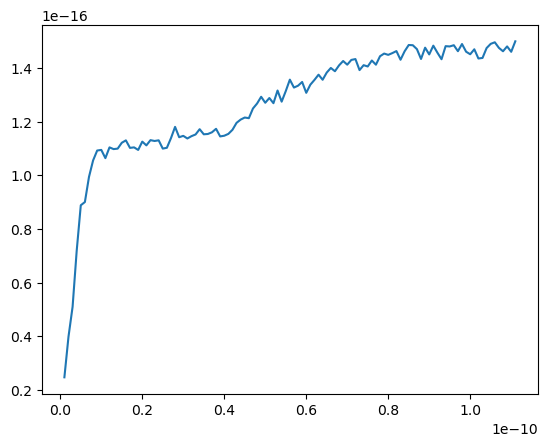

In [87]:
plt.plot(df['Time'],df['OCM'])

In [67]:
simulation = openmm_app.Simulation(
        topology=a[0],
        system=a[1],
        integrator=a[2],
    )

TypeError: 'PDBFile' object is not subscriptable

In [61]:
a=openmm_app.PDBFile('results/box_butanol_100_700/box_butanol_100_650.pdb')

/home/base/miniforge3/envs/MolModel/lib/python3.10/site-packages/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM    2      BUT A   1      11.232  -0.811  23.300  1.00  0.00           C  , HETATM    1      BUT A   1      10.260  -1.792  23.657  1.00  0.00           O  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/base/miniforge3/envs/MolModel/lib/python3.10/site-packages/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM    3      BUT A   1      12.448  -1.512  22.684  1.00  0.00           C  , HETATM    2      BUT A   1      11.232  -0.811  23.300  1.00  0.00           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/base/miniforge3/envs/MolModel/lib/python3.10/site-packages/openmm/app/internal/pdbstructure.py

/home/base/miniforge3/envs/MolModel/lib/python3.10/site-packages/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM  875      BUT C   1      22.488  17.092  24.173  1.00  0.00           H  , HETATM  874      BUT C   1      20.041  15.722  25.409  1.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/base/miniforge3/envs/MolModel/lib/python3.10/site-packages/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM  876      BUT C   1      22.199  16.936  25.908  1.00  0.00           H  , HETATM  875      BUT C   1      22.488  17.092  24.173  1.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/base/miniforge3/envs/MolModel/lib/python3.10/site-packages/openmm/app/internal/pdbstructure.py

In [66]:
a.topology.residues()

<generator object Topology.residues at 0x7fba9455f370>